In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data). 

In [2]:
!wget https://www.dropbox.com/s/4i466z18wsfvefl/faces.zip

!unzip faces.zip

!ls

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/faces/._4084.png  
  inflating: faces/3933.png          
  inflating: __MACOSX/faces/._3933.png  
  inflating: faces/2393.png          
  inflating: __MACOSX/faces/._2393.png  
  inflating: faces/1842.png          
  inflating: __MACOSX/faces/._1842.png  
  inflating: faces/4912.png          
  inflating: __MACOSX/faces/._4912.png  
  inflating: faces/326.png           
  inflating: __MACOSX/faces/._326.png  
  inflating: faces/440.png           
  inflating: __MACOSX/faces/._440.png  
  inflating: faces/9588.png          
  inflating: __MACOSX/faces/._9588.png  
  inflating: faces/8696.png          
  inflating: __MACOSX/faces/._8696.png  
  inflating: faces/6863.png          
  inflating: __MACOSX/faces/._6863.png  
  inflating: faces/454.png           
  inflating: __MACOSX/faces/._454.png  
  inflating: faces/8682.png          
  inflating: __MACOSX/faces/._8682.png  
  inflating: faces/6877.png          
  in

## Dataloader


In [3]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32])])

# Replace the question marks '?' by the necessary code
batch_size = 64

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    im = Image.imread(f"{self.image_path}{self.images[idx]}")
    im = self.transform(im)
    return im

In [4]:
dataset = MyDataset("faces/")

train_loader = DataLoader(dataset, batch_size = batch_size)
batch = next(iter(train_loader))

<ipython-input-3-6d2a70a3d12e>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.image_path}{self.images[idx]}")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the ca

In [5]:
print(batch.shape)

torch.Size([64, 3, 32, 32])


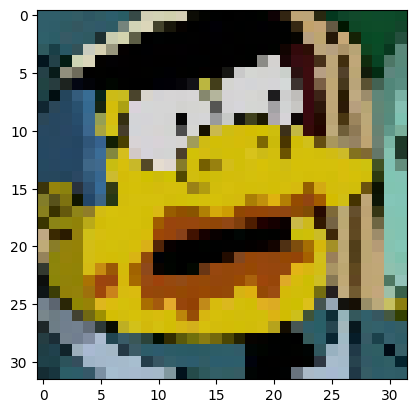

In [6]:
plt.imshow(batch[0,:,:,:].permute(1,2,0))

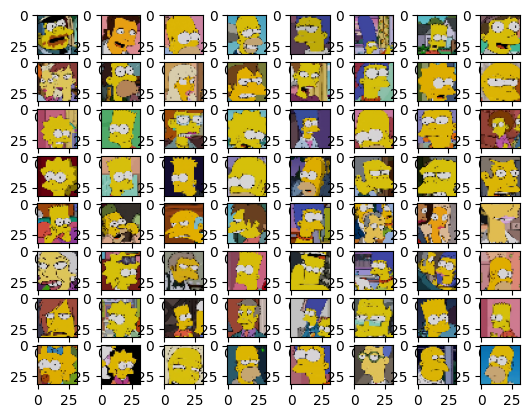

In [7]:
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[i,:,:,:].permute(1, 2, 0))
     

### VAE class
#### Write a VAE class in the following cell

In [8]:
class AutoEncoderConv(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear( 8*8*64, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, nz)


    self.plinear1 = nn.Linear(nz,nz)
    self.plinear2 = nn.Linear(nz,nz)

    self.dlinear1 = nn.Linear(nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 8*8*64)
    self.dbn2 = nn.BatchNorm1d(8*8*64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding= 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding= 1)


  def encoder_head(self, x):
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)
    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)
    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,8*8*64)
    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)
    x = torch.sigmoid(self.elinear2(x))
    return x

  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return (mu, logvar)


  def reparm(self, mu, logvar):
    eps = torch.randn(mu.shape).to(device)
    z = mu + eps* torch.exp(0.5*logvar)
    return z

    # log val =log sigma^2 = 2*log sigma--->. o.5*2*log sigma =log sigma



  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)
    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)
    x = x.view(-1,64 ,8 ,8 )
    x = torch.relu(self.dconv1(x))
    x = self.dbn3(x)
    x = torch.relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x


  def forward(self,x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = self.reparm(mu, logvar)
    x = self.decoder(z)
    return (z, mu, logvar, x)




## Loss 
#### Define Loss function in the following cell

In [9]:

def vae_loss(xhat, x, mu, logvar):
  KL_WEIGHT = 0.00012
  recon_loss = F.mse_loss(xhat, x)
  kl_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar) - mu*mu), axis =1), axis =0)
  return (1-KL_WEIGHT)*recon_loss + (KL_WEIGHT)*kl_loss
     

### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

Adjusting learning rate of group 0 to 1.0000e-03.


<ipython-input-3-6d2a70a3d12e>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.image_path}{self.images[idx]}")


Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 1.2500e-04.
Adjusting learning rate of group 0 to 6.2500e-05.
Adjusting learning rate of group 0 to 3.1250e-05.
Adjusting learning rate of group 0 to 1.5625e-05.
Adjusting learning rate of group 0 to 7.8125e-06.
Adjusting learning rate of group 0 to 3.9063e-06.
Adjusting learning rate of group 0 to 1.9531e-06.
Adjusting learning rate of group 0 to 9.7656e-07.
Adjusting learning rate of group 0 to 4.8828e-07.
Adjusting learning rate of group 0 to 2.4414e-07.
Adjusting learning rate of group 0 to 1.2207e-07.
Adjusting learning rate of group 0 to 6.1035e-08.
Adjusting learning rate of group 0 to 3.0518e-08.
Adjusting learning rate of group 0 to 1.5259e-08.
Adjusting learning rate of group 0 to 7.6294e-09.
Adjusting learning rate of group 0 to 3.8147e-09.
Adjusting learning rate of group 0 to 1.9073e-09.
Adjusting learning rate of group 0 to 9.5367e-10.


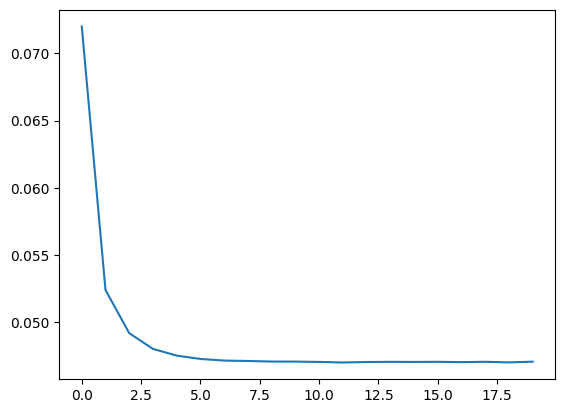

In [10]:
device = torch.device("cuda:0")
nz = 32
net = AutoEncoderConv(nz).to(device)
num_epochs =20
lr = 1e-3
mm = 0.5

optimizer = optim.Adam(net.parameters(), lr = lr)
# Learning rate Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch.to(device)
    Z, mu, logvar, Xhat = net(X)
    loss = vae_loss(Xhat, X, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

  scheduler.step()
  ls.append(total_loss/len(train_loader))


plt.plot(ls)


     

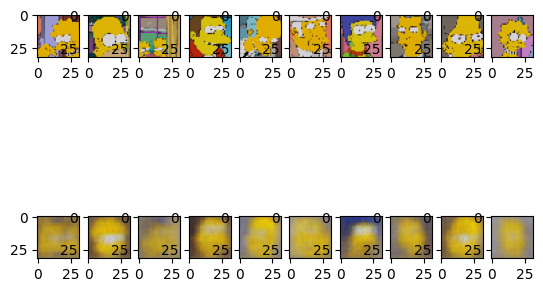

In [11]:

for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X.cpu()[i,:,:,:].permute(1,2,0))
  plt.subplot(2,10,i+11)
  plt.imshow(Xhat[i,:,:,:].detach().cpu().permute(1,2,0))


## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

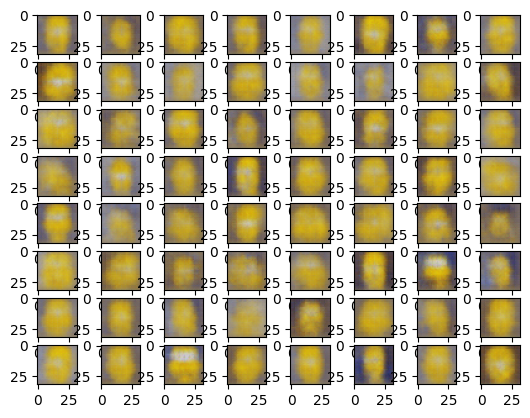

In [12]:

with torch.no_grad():
  net.eval()
  z = torch.randn(64, nz).to(device)

  Xgen = net.decoder(z)


for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(Xgen.cpu()[i,:,:,:].permute(1,2,0))